In [1]:
import matplotlib.pyplot as plt
import numpy as np

##################################################
# specify number of chips you are using for data
TotalChips = int(100)
# Number of Cryocycles
TotalCryo = [5,20,100]
##################################################

# Subrun 0 included, so this is Last Subrun Number + 1
TotalSubruns = int(30)
'''Array format:    array[Cryocycle][chip][channel]'''

chips = []
for i in range(TotalChips):
    a = 'chip' + str(i+20)
    chips.append(a)
data = []; txt = []
for c in range(len(TotalCryo)):
    data.append([]); txt.append([])
for i in range(TotalChips):
    g = 'DataCT5' + '_' + str(chips[i])
    data[0].append(g)
    h = str(chips[i]) + 'CT5Lin.dat'
    txt[0].append(h)
for i in range(TotalChips):
    k = 'DataCT20' + '_' + str(chips[i])
    data[1].append(k)
    l = str(chips[i]) + 'CT20Lin.dat'
    txt[1].append(l)
for i in range(TotalChips):
    k = 'DataCT100' + '_' + str(chips[i])
    data[2].append(k)
    l = str(chips[i]) + 'CT100Lin.dat'
    txt[2].append(l)

channels = 16

PA = []; Ch = []; SR = []
for c in range(len(TotalCryo)):
    PA.append([]); Ch.append([]); SR.append([])
for c in range(len(TotalCryo)):
    for i in range(TotalChips):
        PA[c].append([]); Ch[c].append([]); SR[c].append([])
for c in range(len(TotalCryo)):
    for i in range(TotalChips):
        for j in range(channels):
            PA[c][i].append([]); Ch[c][i].append([]); SR[c][i].append([])
for c in range(len(TotalCryo)):
    for i in range(TotalChips):
        for j in range(channels):
            for k in range(TotalSubruns):
                Ch[c][i][j].append(j)

for c in range(len(TotalCryo)):
    for i in range(TotalChips):
        r = np.loadtxt(str(txt[c][i]),dtype=float,delimiter=None)
        rr = r.T[0]
        p = np.loadtxt(str(txt[c][i]),dtype=float,delimiter=None)
        pulseamp = p.T[2]
        for j in range(channels):
            for k in range(TotalSubruns):
                PA[c][i][j].append(pulseamp[j+k*16])
                SR[c][i][j].append(rr[j+k*16])

print('done')

done


In [2]:
def LinearityFitter(Subrun,Pulse,chipindex,cryo):
    x = np.array(Subrun)
    T = np.array(Pulse)
    sigma = np.ones(x.size)*50

    S = np.sum(1./sigma**2.)
    Sx = np.sum(x/sigma**2.)
    Sy = np.sum(T/sigma**2.)
    Sxx = np.sum(x**2./sigma**2.)
    Sxy = np.sum(x*T/sigma**2.)

    A = np.array([[S,Sx],[Sx,Sxx]])
    b = np.array([Sy,Sxy])

    a = np.linalg.solve(A,b)
    fit = a[0]+a[1]*x

    #linear_coeff.append(a[1])
    LCoeff[cryo][chipindex].append(a[1])
    
    chisq = np.sum((T-fit)**2./sigma**2.)
    nf = x.size-a.size
    chi_red = chisq/nf
    
    #chi2.append((chi_red))
    
    return

LCoeff = []
for c in range(len(TotalCryo)):
    LCoeff.append([])
for c in range(len(TotalCryo)):
    for i in range(len(chips)):
        LCoeff[c].append([])
for c in range(len(TotalCryo)):
    for i in range(len(chips)):
        for j in range(channels):
            Subrun = SR[c][i][j]
            Pulse = PA[c][i][j]
            chipindex = i
            cryo = c
            LinearityFitter(Subrun,Pulse,chipindex,cryo)

print('done')

done


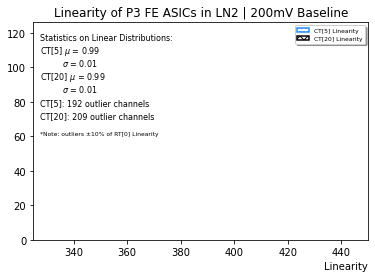


Mean of CT[5] Distribution =  0.99
Sigma of CT[5] Distribution =  0.01

Mean of CT[20] Distribution =  0.99
Sigma of CT[20] Distribution =  0.01


In [3]:
from statistics import NormalDist

# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Statistics on just the "peaked" normal distribution
LC = []; bad_channel_counter = []
for c in range(len(TotalCryo)):
    LC.append([])
for c in range(len(TotalCryo)):
    count = 0.
    for i in range(len(chips)):
        for j in range(len(LCoeff[c][i])):
            if 350 < LCoeff[c][i][j] < 450:
                LC[c].append(LCoeff[c][i][j])
            else:
                count = count + 1
    bad_channel_counter.append(count)


norm_5 = NormalDist.from_samples(LC[0])
mean_5 = norm_5.mean; std_5 = norm_5.stdev
m5 = r'$\mu$' + ' = ' + str(round(mean_5,1))
s5 = r'$\sigma$' + ' = ' + str(round(std_5,1))

norm_20 = NormalDist.from_samples(LC[1])
mean_20 = norm_20.mean; std_20 = norm_20.stdev
m20 = r'$\mu$' + ' = ' + str(round(mean_20,1))
s20 = r'$\sigma$' + ' = ' + str(round(std_20,1))   

# # # # # # # # # # # # # # # # # # # # # # # # # # # #

fig, ax = plt.subplots()
ax.set_title('Linearity of P3 FE ASICs in LN2 | 200mV Baseline')
ax.set_xlabel('Least Square Fit Linear Coefficient Value [adc/Subrun]', loc = 'right')

# proper binning
c = max(LC[0])-min(LC[0]); d = max(LC[1])-min(LC[1])
ratio = d/c
bins5 = 100; bins20 = int(bins5*ratio)

ax.hist(LC[0], bins = bins5, histtype = 'step', hatch = '...', stacked = False,
        color = 'dodgerblue', linewidth = 1.5, label = 'CT[5] Linearity')
ax.hist(LC[1], bins = bins20, histtype = 'step', hatch = 'xxx', stacked = False,
        color = 'black', linewidth = 1.5, label = 'CT[20] Linearity')

# Labeling Mean, sigma on plot
ax.text(.02,0.92,'Statistics on Linear Distributions:',size = 8,transform = ax.transAxes)
ax.text(.02,0.86,'CT[5] ' + m5,size = 8,transform = ax.transAxes)
ax.text(.085,0.80,s5,size = 8,transform = ax.transAxes)
ax.text(.02,0.74,'CT[20] ' + m20,size = 8,transform = ax.transAxes)
ax.text(.085,0.68,s20,size = 8,transform = ax.transAxes)

# How many channels were omitted from the nominal distribution
ax.text(.02,0.62,'CT[5]: ' + str(round(bad_channel_counter[0])) + ' outlier channels',size = 8,transform = ax.transAxes)
ax.text(.02,0.56,'CT[20]: ' + str(round(bad_channel_counter[1])) + ' outlier channels',size = 8,transform = ax.transAxes)
ax.text(.02,0.48,'*Note: outlier outside of [350:450] range',size = 6,transform = ax.transAxes)

plt.xlim([325,450])

plt.legend(shadow=True, loc = 'upper right', prop={'size': 6})
path2 = '../../../../../CT Linearity.png'
plt.savefig(path2,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

print('\nMean of RT[5] Distribution = ', round(mean_5,2))
print('Sigma of RT[5] Distribution = ', round(std_5,2))
print('\nMean of RT[20] Distribution = ', round(mean_20,2))
print('Sigma of RT[20] Distribution = ', round(std_20,2))

### Full x-scale (from 0 to 450)

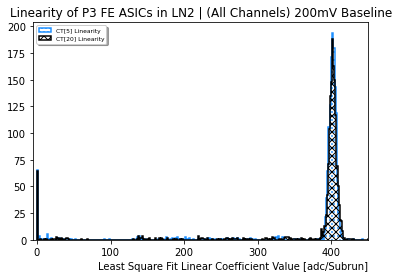

In [4]:
from statistics import NormalDist

# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Statistics on just the "peaked" normal distribution
LC_all = []
for c in range(len(TotalCryo)):
    LC_all.append([])
for c in range(len(TotalCryo)):
    count = 0.
    for i in range(len(chips)):
        for j in range(len(LCoeff[c][i])):
            LC_all[c].append(LCoeff[c][i][j])

# # # # # # # # # # # # # # # # # # # # # # # # # # # #

fig, ax = plt.subplots()
ax.set_title('Linearity of P3 FE ASICs in LN2 | (All Channels) 200mV Baseline')
ax.set_xlabel('Least Square Fit Linear Coefficient Value [adc/Subrun]', loc = 'right')

# proper binning
c = max(LC_all[0])-min(LC_all[0]); d = max(LC_all[1])-min(LC_all[1]); e = max(LC_all[2]) - min(LC_all[2])
ratio = d/c; ratio_1 = e/c
bins5 = 300; bins20 = int(bins5*ratio); bins100 = int(bins5*ratio_1)

ax.hist(LC_all[0], bins = bins5, histtype = 'step', hatch = '...', stacked = False,
        color = 'dodgerblue', linewidth = 1.5, label = 'CT[5] Linearity')
ax.hist(LC_all[1], bins = bins20, histtype = 'step', hatch = 'xxx', stacked = False,
        color = 'black', linewidth = 1.5, label = 'CT[20] Linearity')
ax.hist(LC_all[2], bins = bins100, histtype = 'step', hatch = '///', stacked = False,
        color = 'red', linewidth = 1.5, label = 'CT[100] Linearity')

plt.xlim([-5,450])

plt.legend(shadow=True, loc = 'upper left', prop={'size': 6})
path2 = '../../../../../CT (Full Scale, all Channels) Linearity.png'
plt.savefig(path2,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

In [7]:
mean = [mean_5, mean_20]
std = [std_5, std_20]

for i in range(len(TotalCryo)):

    print('############## CT[' + str(TotalCryo[i]) + '] ##############')
    print('Linearity', '\nμ =', round(mean[i],2), '| σ =', round(std[i],2))
    print('3σ =', '±', round(3*std[i],2), '| 5σ =', '±', round(5*std[i],2))
    print('X-lim 3σ range = [', round(mean[i] - 3*std[i],2), ',', round(mean[i] + 3*std[i],2), ']')
    print('X-lim 5σ range = [', round(mean[i] - 5*std[i],2), ',', round(mean[i] + 5*std[i],2), ']')

    # Statistics on number of channels that were outside the 5-sigma window
    hm = 0.
    for j in range(len(LCoeff[i])):
        for k in range(len(LCoeff[i][j])):
            # 5-sigma deviation from the mean
            if LCoeff[i][j][k] > (mean[i] + 5*std[i]) or LCoeff[i][j][k] < (mean[i] - 5*std[i]):  
                hm = hm + 1
    
    print(str(hm) + '/' + str(len(LCoeff[i]*16)) + ' Channels with values outside of 5σ from mean of Nominal Linearity distribution')
    print(str(round(100*(hm/len(LCoeff[i]*16)),2)) + ' % of total channels displayed non-Linearity')

    # Statistics on number of chips that had non-linear channels
    count = []
    for j in range(len(LCoeff[i])):
        if any(e > (mean[i] + 5*std[i]) or e < (mean[i] - 5*std[i]) for e in LCoeff[i][j]):
            count.append(j+20)
    print('\n' + str(len(count)) + ' Chips with at least one channel outside of 5σ from mean of Nominal Linearity distribution')
    print(str(round(100*(len(count)/TotalChips),2))+ ' % of chips with at least one non-linear channel')
    print(count,'\n')


############## CT[5] ##############
Linearity 
μ = 401.49 | σ = 5.6
3σ = ± 16.8 | 5σ = ± 28.0
X-lim 3σ range = [ 384.69 , 418.29 ]
X-lim 5σ range = [ 373.5 , 429.49 ]
196.0/1600 Channels with values outside of 5σ from mean of Nominal Linearity distribution
12.25 % of total channels displayed non-Linearity

31 Chips with at least one channel outside of 5σ from mean of Nominal Linearity distribution
31.0 % of chips with at least one non-linear channel
[20, 27, 29, 31, 33, 37, 41, 48, 51, 53, 54, 58, 61, 68, 71, 75, 77, 80, 84, 88, 89, 95, 97, 98, 99, 101, 103, 108, 110, 111, 118] 

############## CT[20] ##############
Linearity 
μ = 401.82 | σ = 6.39
3σ = ± 19.18 | 5σ = ± 31.97
X-lim 3σ range = [ 382.63 , 421.0 ]
X-lim 5σ range = [ 369.84 , 433.79 ]
209.0/1600 Channels with values outside of 5σ from mean of Nominal Linearity distribution
13.06 % of total channels displayed non-Linearity

27 Chips with at least one channel outside of 5σ from mean of Nominal Linearity distribution
27.0 % o

In [8]:
'''Save data for histograms to .dat file'''

file0 = open('CT5_Linearity_Histogram_Data.dat', "w")
for i in range(len(LC[0])):             # CT[5]
    file0.write(str(LC[0][i]) + '\n')
file0.close()

file1 = open('CT20_Linearity_Histogram_Data.dat', "w")
for i in range(len(LC[1])):             # CT[20]
    file1.write(str(LC[1][i]) + '\n')
file1.close()

print('done')

done


### Normalized Linearity

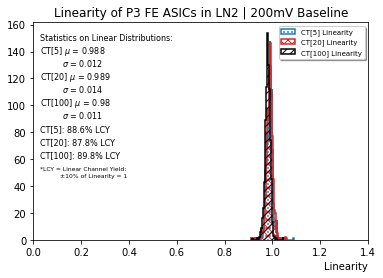


Mean of CT[5] Distribution =  0.99
Sigma of CT[5] Distribution =  0.01

Mean of CT[20] Distribution =  0.99
Sigma of CT[20] Distribution =  0.01

Mean of CT[100] Distribution =  0.98
Sigma of CT[100] Distribution =  0.01


In [10]:
'''
Here, we define the mean of the RT[0] distribution as being linearity 1, so every other
distribution is normalized to RT[0], including CT distributions
'''

from statistics import NormalDist

'''
Mean of RT[0] Distribution: 406.53
'''
Normalized_Mean = 406.53
plus_10 = 406.53 + 406.53*.1
minus_10 = 406.53 - 406.53*.1

'''
Total Number of Channels, excluding disconnections for CT:
CT[5]:  1590
CT[20]:  1584
CT[100]:  1524
'''
CC5 = 1590
CC20 = 1584
CC100 = 1524

# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Statistics on just the "peaked" normal distribution
LC = []; counter = []
for c in range(len(TotalCryo)):
    LC.append([]); counter.append([])
for c in range(len(TotalCryo)):
    count = 0.
    for i in range(len(chips)):
        for j in range(len(LCoeff[c][i])):
            if minus_10 < LCoeff[c][i][j] < plus_10:   # Define range +/-10%
                LC[c].append(LCoeff[c][i][j])
    
    count = len(LC[c])
    counter[c].append(count)
    

# Normalization
for c in range(len(TotalCryo)):
    for i in range(len(LC[c])):
        LC[c][i] = LC[c][i]/Normalized_Mean
        

norm_5 = NormalDist.from_samples(LC[0])
mean_5 = norm_5.mean; std_5 = norm_5.stdev
m5 = r'$\mu$' + ' = ' + str(round(mean_5,3))
s5 = r'$\sigma$' + ' = ' + str(round(std_5,3))

norm_20 = NormalDist.from_samples(LC[1])
mean_20 = norm_20.mean; std_20 = norm_20.stdev
m20 = r'$\mu$' + ' = ' + str(round(mean_20,3))
s20 = r'$\sigma$' + ' = ' + str(round(std_20,3))   

norm_100 = NormalDist.from_samples(LC[2])
mean_100 = norm_100.mean; std_100 = norm_100.stdev
m100 = r'$\mu$' + ' = ' + str(round(mean_100,3))
s100 = r'$\sigma$' + ' = ' + str(round(std_100,3))   

# # # # # # # # # # # # # # # # # # # # # # # # # # # #

fig, ax = plt.subplots()
ax.set_title('Linearity of P3 FE ASICs in LN2 | 200mV Baseline')
ax.set_xlabel('Linearity', loc = 'right')

# proper binning
c = max(LC[0])-min(LC[0]); d = max(LC[1])-min(LC[1]); e = max(LC[2])-min(LC[2])
ratio = d/c; ratio_1 = e/c
bins5 = 70; bins20 = int(bins5*ratio); bins100 = int(bins5*ratio_1)

ax.hist(LC[0], bins = bins5, histtype = 'step', hatch = '...', stacked = False,
        color = 'tab:blue', linewidth = 1.5, label = 'CT[5] Linearity')
ax.hist(LC[1], bins = bins20, histtype = 'step', hatch = 'xxx', stacked = False,
        color = 'tab:red', linewidth = 1.5, label = 'CT[20] Linearity')
ax.hist(LC[2], bins = bins100, histtype = 'step', hatch = '///', stacked = False,
        color = 'black', linewidth = 1.5, label = 'CT[100] Linearity')

# Labeling Mean, sigma on plot
ax.text(.02,0.92,'Statistics on Linear Distributions:',size = 8,transform = ax.transAxes)
ax.text(.02,0.86,'CT[5] ' + m5,size = 8,transform = ax.transAxes)
ax.text(.085,0.80,s5,size = 8,transform = ax.transAxes)
ax.text(.02,0.74,'CT[20] ' + m20,size = 8,transform = ax.transAxes)
ax.text(.085,0.68,s20,size = 8,transform = ax.transAxes)
ax.text(.02,0.62,'CT[100] ' + m100,size = 8,transform = ax.transAxes)
ax.text(.085,0.56,s100,size = 8,transform = ax.transAxes)

# How many channels were omitted from the nominal distribution
ax.text(.02,0.50,'CT[5]: ' + str(round((counter[0][0]/CC5)*100,1)) + '% LCY',size = 8,transform = ax.transAxes)
ax.text(.02,0.44,'CT[20]: ' + str(round((counter[1][0]/CC20)*100,1)) + '% LCY',size = 8,transform = ax.transAxes)
ax.text(.02,0.38,'CT[100]: ' + str(round((counter[2][0]/CC100)*100,1)) + '% LCY',size = 8,transform = ax.transAxes)
ax.text(.02,0.32,'*LCY = Linear Channel Yield:', size = 6,transform = ax.transAxes)
ax.text(.08,0.29,u"\u00B1" + '10% of Linearity = 1', size = 6,transform = ax.transAxes) 

#plt.xlim([0.88,1.06])
# Zoomed out version:
plt.xlim([0,1.4])

plt.legend(shadow=True, loc = 'upper right', prop={'size': 7})
path2 = '../../../../../CT Normalized (zoomed out) Linearity.png'
plt.savefig(path2,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

print('\nMean of CT[5] Distribution = ', round(mean_5,2))
print('Sigma of CT[5] Distribution = ', round(std_5,2))
print('\nMean of CT[20] Distribution = ', round(mean_20,2))
print('Sigma of CT[20] Distribution = ', round(std_20,2))
print('\nMean of CT[100] Distribution = ', round(mean_100,2))
print('Sigma of CT[100] Distribution = ', round(std_100,2))

In [4]:
print(counter)

[[1408], [1391], [1369]]


### Simulation of what a ~1% difference in Linearity Distribution looks like when plotted as waveform

done

done


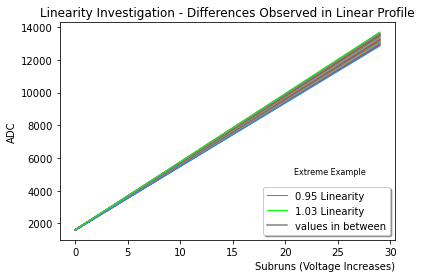

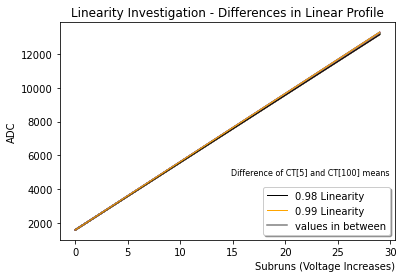

In [43]:
def funct(x,m):
    return m*x + 1600    # Pedestal Mean (baseline) in CT ~1600

x = []; m = []

# Only interested in first 30 SRs to avoid saturation
# must include 0 here since we assigned a value for a[0] above (mx + b --> value of b)
for i in range(0,30):
    x.append(i)
    
# RT[0] mean = 406.53
# Run values of m from 0.95 -> 1.03, must convert to linear coeff. values
# 0.95 = 386.2035    1.03 = 418.7259   for the extreme ends of the distributions
# if you go by step of 1, that is 33 points. We need 30 to match, so tighten the range slightly
for i in range(388,418,1):
    m.append(i)

y = []
for i in range(0,30):
    y.append([])

# extract values for y, given values of m and x
for i in range(len(m)):
    for j in range(len(x)):
        a = funct(x[j], m[i])
        y[i].append(a)

# # # # # # # # # # # # # # # # # # #
fig, ax = plt.subplots()
# Highlight extremes
plt.plot(x, y[0], color = 'dodgerblue', linewidth = 1, zorder = 50, label = '0.95 Linearity')
plt.plot(x,y[-1], color = 'lime', linewidth = 1, zorder = 50, label = '1.03 Linearity')

# For all other lines in between
for i in range(1,len(y)-1):
    if i == len(y) - 2:
        plt.plot(x,y[i], label = 'values in between')
    else:
        plt.plot(x,y[i])
    
plt.legend(shadow = True, loc = 'lower right')
plt.title('Linearity Investigation - Differences Observed in Linear Profile')
plt.xlabel('Subruns (Voltage Increases)', loc = 'right')
plt.ylabel('ADC')
ax.text(.70,0.30,'Extreme Example',size = 8,transform = ax.transAxes)
path2 = '../../../../../test.png'
plt.savefig(path2,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

print('done\n')
##################################################################
# True difference in the means
x = []; m = []

for i in range(0,30):
    x.append(i)
    
# RT[0] mean = 406.53
# Run values of m from 0.98 -> 0.99 (difference in means of CT[5] and CT[100]
# --> Must convert to linear coeff. values
# 0.98 = 398.3994    0.99 = 402.4647   
# if you go by step of 1, that is only 5 points. We need 30 to match, so we multiply the range by 6,
# so we can step by 1 properly. Then we'll divide by 6 after (stupid python integer step size).
for i in range(398*6,403*6,1):
    m.append(i)
for i in range(len(m)):
    m[i] = m[i]/6

y = []
for i in range(0,30):
    y.append([])

# extract values for y, given values of m and x
for i in range(len(m)):
    for j in range(len(x)):
        a = funct(x[j], m[i])
        y[i].append(a)

# # # # # # # # # # # # #
fig, ax = plt.subplots()
plt.plot(x, y[0], color = 'black', linewidth = 1, zorder = 50, label = '0.98 Linearity')
plt.plot(x,y[-1], color = 'orange', linewidth = 1, zorder = 50, label = '0.99 Linearity')

# For all other lines in between
for i in range(1,len(y)-1):
    if i == len(y) - 2:
        plt.plot(x,y[i], label = 'values in between')
    else:
        plt.plot(x,y[i])
    
plt.legend(shadow = True, loc = 'lower right')
plt.title('Linearity Investigation - Differences in Linear Profile')
plt.xlabel('Subruns (Voltage Increases)', loc = 'right')
plt.ylabel('ADC')
ax.text(.51,0.30,'Difference of CT[5] and CT[100] means',size = 8,transform = ax.transAxes)
path2 = '../../../../../test1.png'
plt.savefig(path2,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')


print('done')